# P. halepensis model, ages and transit time calculations and simulations 

The objective of this notebook is to describe and make available all the code used to get the results for _P. halepensis_ presented in the manuscript "Probability distributions of non-structural carbon ages and transit times provide insights in carbon allocation dynamics of mature trees". 

1. we loaded all the dependencies for the code to run. 
   
Sometimes packages changes. You may need to check for functional changes in the packages listed below and adapt the code if necessary. 

In [1]:
from CompartmentalSystems.smooth_reservoir_model import SmoothReservoirModel
from CompartmentalSystems.smooth_model_run import SmoothModelRun 
from CompartmentalSystems.start_distributions import start_age_distributions_from_steady_state,start_age_moments_from_steady_state
from sympy import Symbol, symbols, Function
from plotly.offline import plot
import numpy as np
import matplotlib
#matplotlib.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt

2. We defined the names of the fluxes and state variables. Then, the function f_expr is created to introduce the simulations, which consisted in runing the model in steady state for 10 years and then cut all the incomes to cero for 40 subsequent years. Afterward we defined the relations between the fluxes and the pools in our model, described in the Fig 2 of the mansucript. 


In [2]:
FSNSC, FANSC, FB = symbols('FSNSC FANSC FB') 
SANSC, SSNSC, SB =symbols('SANSC SSNSC SB')
RANSC, RSNSC, RB =symbols('RANSC RSNSC RB')
Rf, Lf, Cf, FtoS, Sf,Gf = symbols('Rf Lf Cf FtoS Sf Gf')
StoF, Rs, Ss, Cs, Gs, Ls, Stor =symbols('StoF Rs Ss Cs Gs Ls Stor')
Rr, Sr, Cr, Gr, Lr, rtoS =symbols('Rr Sr Cr Gr Lr rtoS')
state_vector = [FANSC, FSNSC, SANSC, SSNSC,RANSC, RSNSC]
t = Symbol('t')

f_expr = Function('f')(t)

def f_step(t):
    t_step=10
    val=23000 if t<t_step else 0
    return val

func_set_step = {f_expr: f_step}

input_fluxes = {0: f_expr} 
output_fluxes = {
    0:Rf*FANSC+Gf*FANSC, 
    2:Rs*SANSC+Gs*SANSC,
    4:Rr*RANSC+Gr*RANSC
    }

internal_fluxes = {
    (1,0):Cf*FSNSC, 
    (0,1):Sf*FANSC, 
    (0,2):FtoS*FANSC,
    (2,0):StoF*SANSC,
    (2,3):Ss*SANSC,
    (2,4):Stor*SANSC,
    (3,2):Cs*SSNSC,
    (4,5):Sr*RANSC,
    (5,4):Cr*RSNSC,
    (4,2):rtoS*RANSC
    }



3. The smooth reservoir model (srm) should be build using the fluxes and state vector described before.The values of the parameters and the starting point are also declared here. The values of the parametes are given in the Table 1 of the manuscript and the code that was used to calculated them is named "P.halepensis_parameter_calculations.R"

In [3]:
srm = SmoothReservoirModel(state_vector, t, input_fluxes, output_fluxes, internal_fluxes)
#t0=0 ##start value default 
start_t=0 ## start value
parameter_set={
        Rf:9.56, 
        Cf:2.02, 
        FtoS:33.7, 
        Sf:0.44, 
        Gf:2.94,
        StoF:0.04,
        Rs:0.59,
        Cs:1.09,
        Ss:0.80,
        Gs:0.30,
        Rr:16.84,
        Stor:3.15,
        Sr:4.98,
        Cr:1.22,
        Gr:1.28,
        rtoS:0.11, #this flux goes from the pool 6 (RLNSC) ot the pool 3 (SLNSC). 
        }

4.  The start age distributions (distributions in steady state) are computed here

In [4]:
a_dens_function,x_fix = start_age_distributions_from_steady_state(
    srm,
    t0=start_t,
    parameter_dict=parameter_set,
    func_set=func_set_step
)
print("fixpoint", x_fix)

times = np.linspace(start_t,50,50)
smr = SmoothModelRun(srm, parameter_dict=parameter_set, start_values=x_fix, times=times,func_set=func_set_step)


############################################
in function: lapm_for_steady_state
x_fix = [ 501.43823965  109.22417101 4161.16679386 3054.06737164  719.01675264
 2935.00280996]
 type: <class 'numpy.ndarray'>
############################################
############################################
in function: lapm_for_steady_state
B0 = [[-4.664e+01  2.020e+00  4.000e-02  0.000e+00  0.000e+00  0.000e+00]
 [ 4.400e-01 -2.020e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 3.370e+01  0.000e+00 -4.880e+00  1.090e+00  1.100e-01  0.000e+00]
 [ 0.000e+00  0.000e+00  8.000e-01 -1.090e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  3.150e+00  0.000e+00 -2.321e+01  1.220e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  4.980e+00 -1.220e+00]]
 type: <class 'numpy.ndarray'>
############################################
############################################
in function: lapm_for_steady_state
u0 = [[23000]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]]
 type: <class 'numpy.ndarray'>
##

5. We constructed a function p that takes an age array (ages) as argument and give back a three dimensional ndarray (ages x times x pools) from the a array-value function of a single age a_dens_function. Ages specify the amount of times the model is ran (start_year, end_year, number_of_points). Then we ran our function p along the age vector and extracted the system age density distribution (system_dens_data).

In [5]:
p=smr.pool_age_densities_func(a_dens_function)
ages=np.linspace(0,10,200)
pool_dens_data=p(ages)
system_dens_data=smr.system_age_density(pool_dens_data)

100%|██████████| 200/200 [03:31<00:00,  1.63s/it]


6. The mean age for each time steps and each pool is clcualted in start_mean_ages

In [6]:
start_mean_ages=start_age_moments_from_steady_state(
    srm,
    t0=start_t,
    parameter_dict=parameter_set,
    func_set=func_set_step,
    max_order=1
)

############################################
in function: lapm_for_steady_state
x_fix = [ 501.43823965  109.22417101 4161.16679386 3054.06737164  719.01675264
 2935.00280996]
 type: <class 'numpy.ndarray'>
############################################
############################################
in function: lapm_for_steady_state
B0 = [[-4.664e+01  2.020e+00  4.000e-02  0.000e+00  0.000e+00  0.000e+00]
 [ 4.400e-01 -2.020e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 3.370e+01  0.000e+00 -4.880e+00  1.090e+00  1.100e-01  0.000e+00]
 [ 0.000e+00  0.000e+00  8.000e-01 -1.090e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  3.150e+00  0.000e+00 -2.321e+01  1.220e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  4.980e+00 -1.220e+00]]
 type: <class 'numpy.ndarray'>
############################################
############################################
in function: lapm_for_steady_state
u0 = [[23000]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]]
 type: <class 'numpy.ndarray'>
##

7. The system mean age for each time step of the model run is calculated in mean_sys_age. The mean system age for the steady state is shown in the first 10 time steps, we chose the time 1 to retrieve the mean system age for steady state. 

In [7]:
mean_sys_age=smr.system_age_moment(1, start_mean_ages)
mean_sys_age[1]

0.9822200533680565

8. We plotted the system density distribution of the NSC given by system_dens_data and the density distribution of each NSC pool given by pool_dens_data. For making this plot it was necesary to import a new dependency "Subplot". This is the P. halepensis chart of the figure 3 in the manuscript.

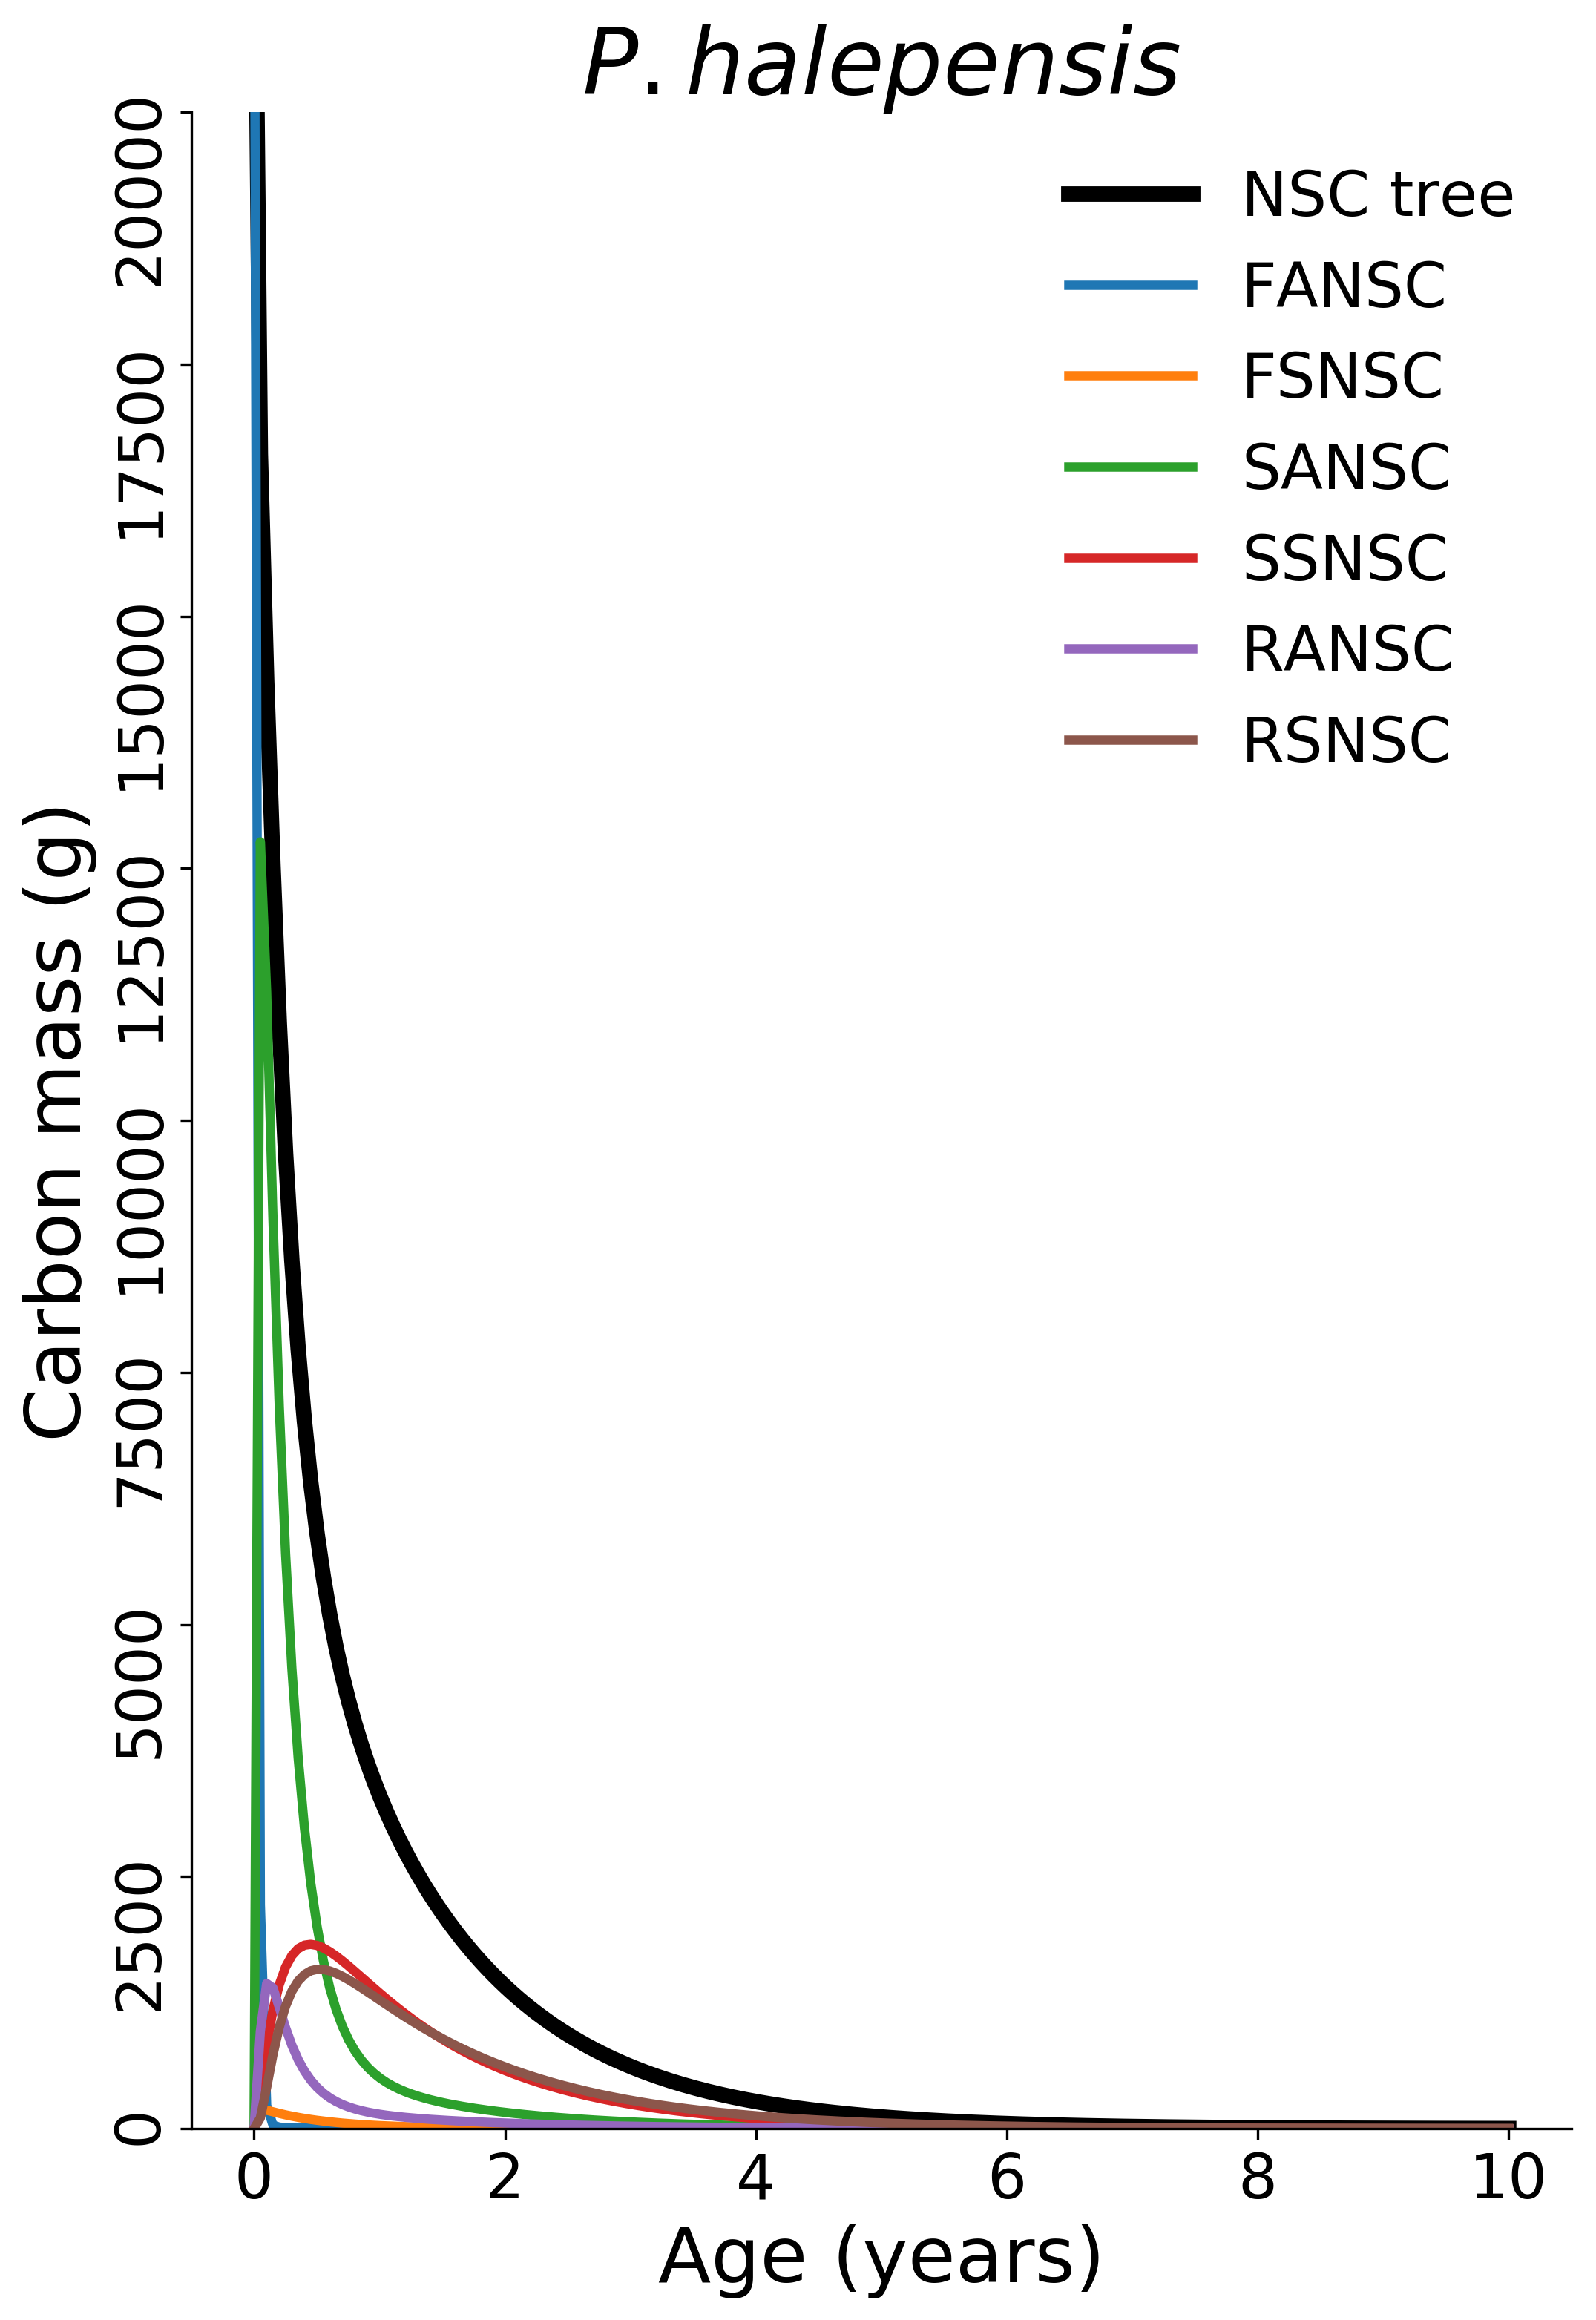

In [8]:
from mpl_toolkits.axisartist.axislines import Subplot
fig=plt.figure(figsize=(8,12), dpi=300)
ax=plt.subplot()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(ages, system_dens_data[:,1], color="black", linewidth=5)
ax.plot(ages, pool_dens_data[:,1,:], linewidth=3)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.yticks(rotation=90)
plt.xlabel('Age (years)', fontsize=25)
plt.ylabel('Carbon mass (g)',fontsize=25)
plt.ylim(0,20000)
plt.title('$\it{P. halepensis}$', fontsize=30)
plt.legend(["NSC tree","FANSC", "FSNSC", "SANSC", "SSNSC","RANSC", "RSNSC"], fontsize=20, frameon=False)


#plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/NSC_ages_and_transit_times/code/P_halepensis/P_halepensis_NSCagedist.png', dpi=300)
#plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/NSC_ages_and_transit_times/code/P_halepensis/P_halepensis_NSCagedist.pdf', dpi=300)

plt.show()


9. Here we plotted the figure of P. halepensis for the Figure 4 of the manuscript. In the figure we show how does the system age density looks like during steady state (black line, 0 years after disturbance) and after some years of disturbance (cero income of carbon). 

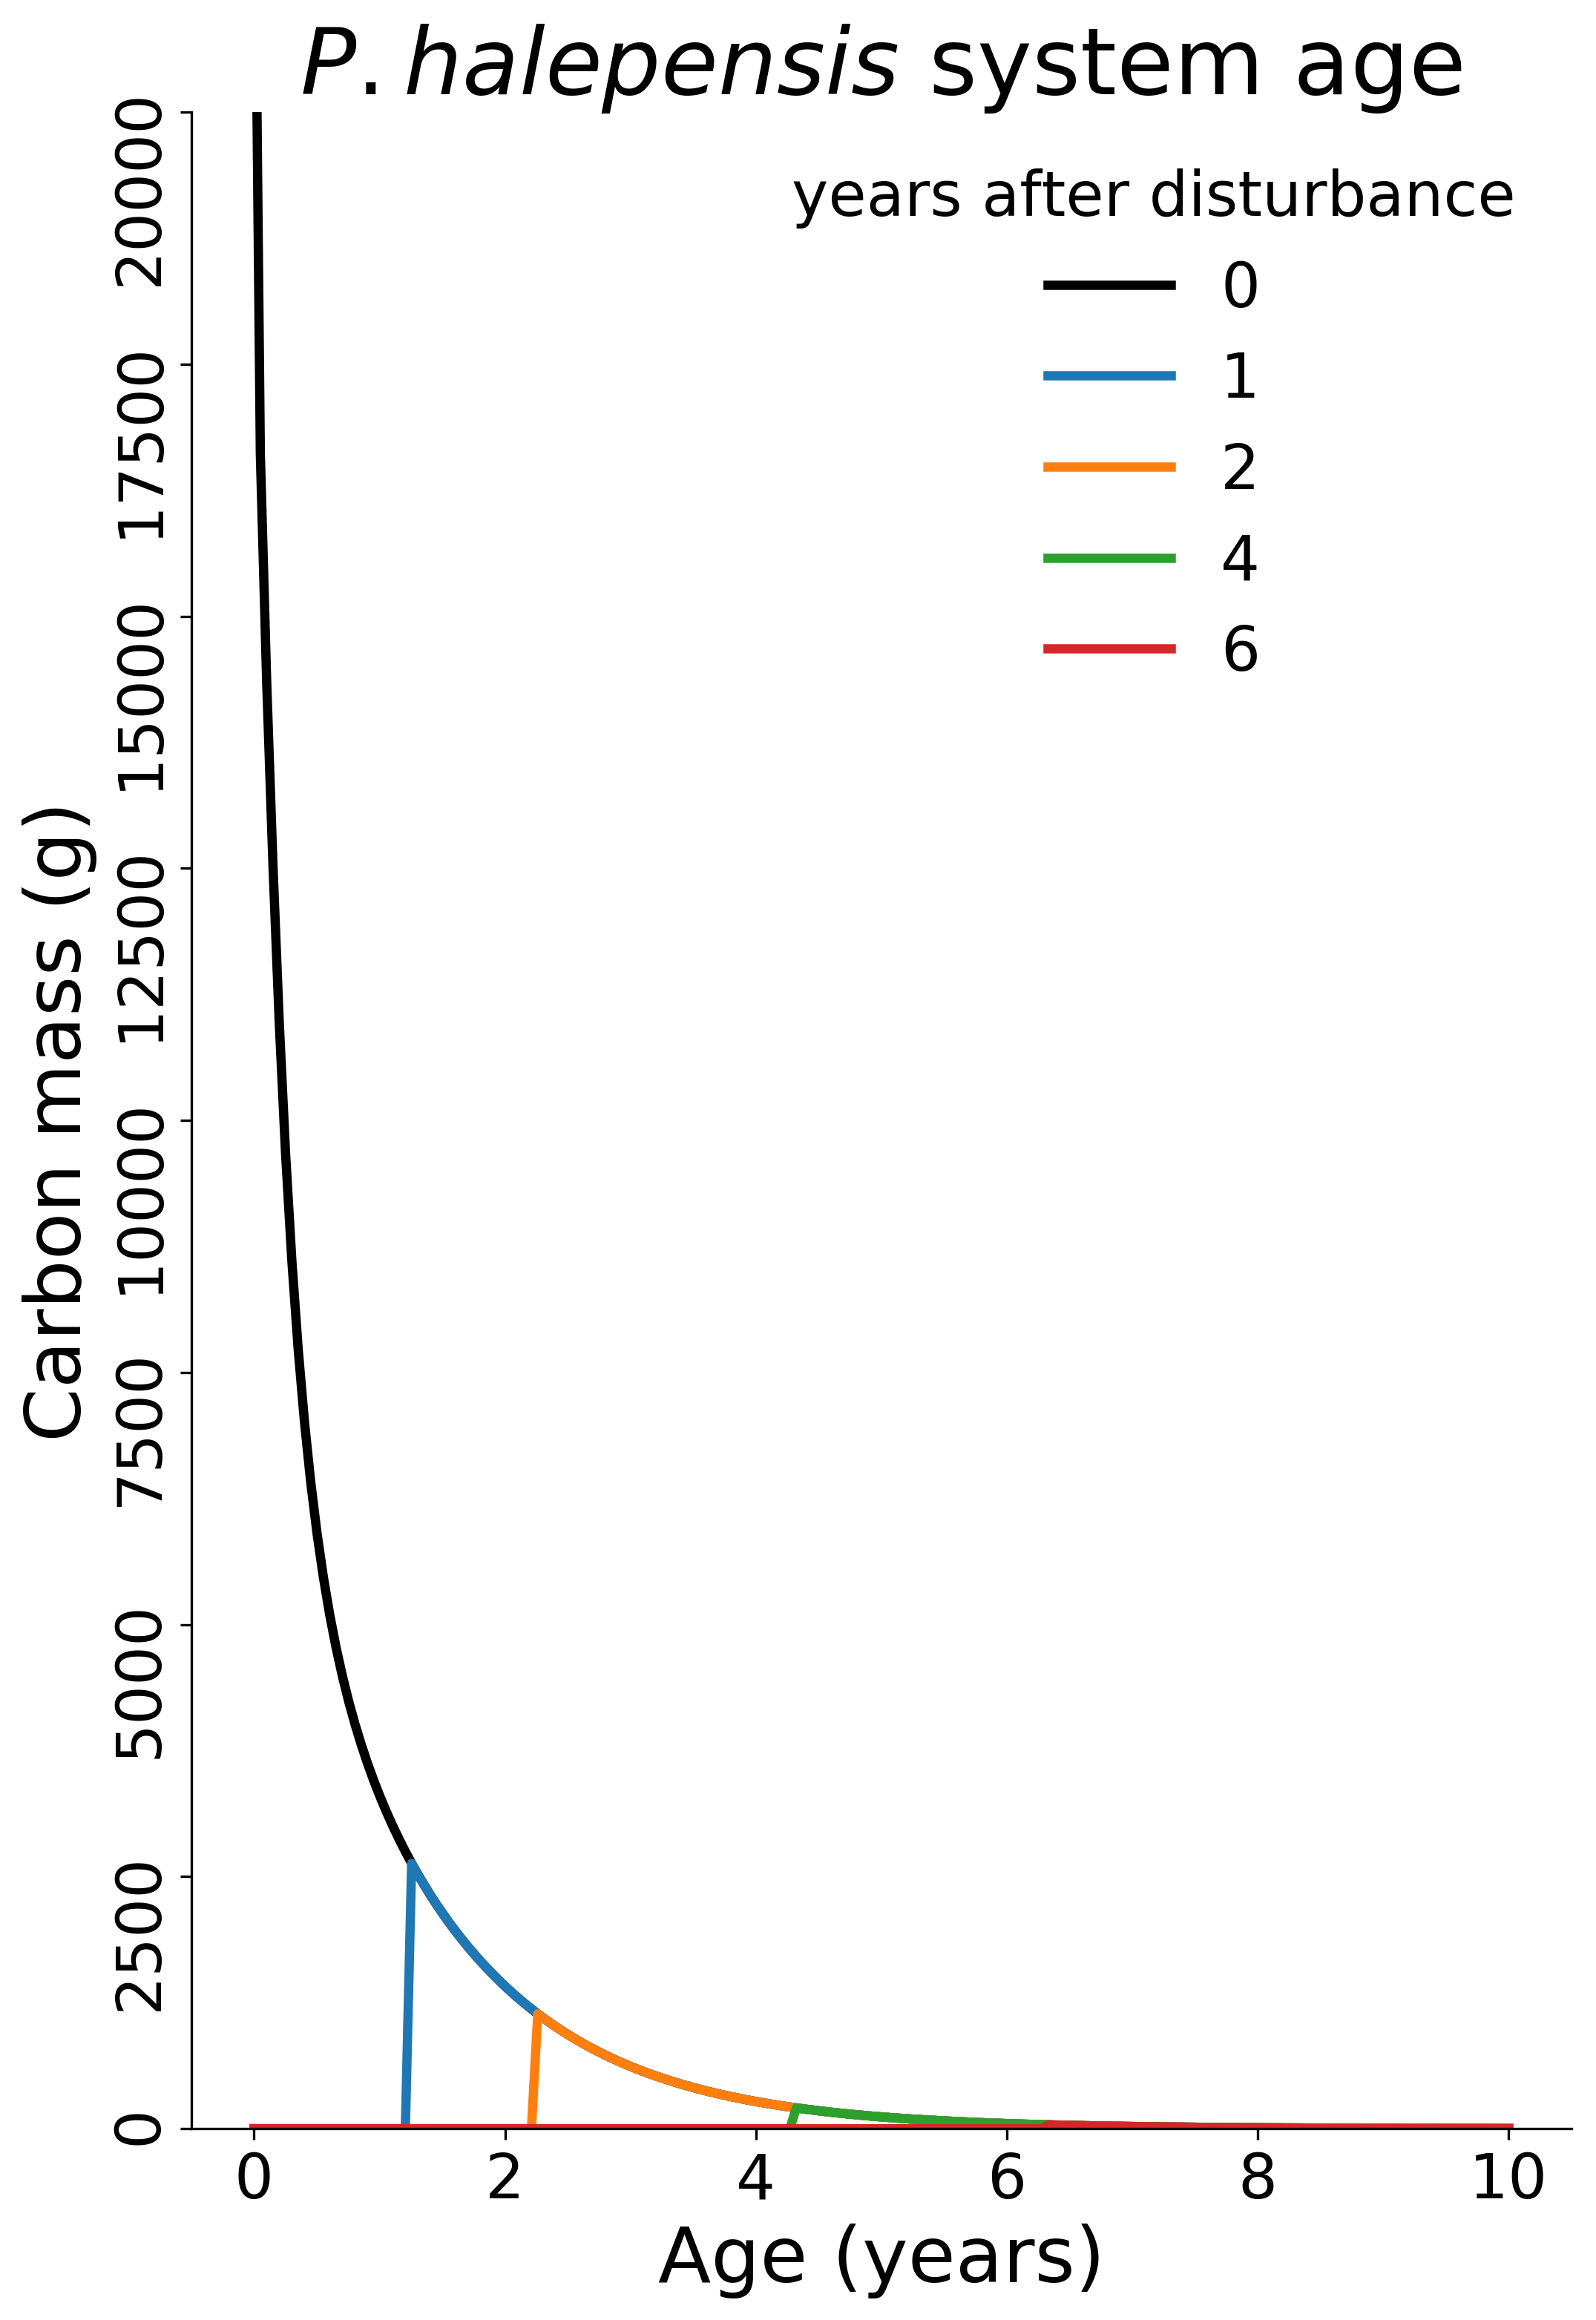

In [9]:
from mpl_toolkits.axisartist.axislines import Subplot
fig=plt.figure(figsize=(8,12), dpi=300)
ax=plt.subplot()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(ages, system_dens_data[:,1], color="black", linewidth=3)
ax.plot(ages, system_dens_data[:,11], color="#1f77b4",linewidth=3)
ax.plot(ages, system_dens_data[:,12], color="#ff7f0e",linewidth=3)
ax.plot(ages, system_dens_data[:,14], color="#2ca02c",linewidth=3)
ax.plot(ages, system_dens_data[:,16], color="#d62728",linewidth=3)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.yticks(rotation=90)
plt.xlabel('Age (years)', fontsize=25)
plt.ylabel('Carbon mass (g)',fontsize=25)
plt.ylim(0,20000)
plt.title('$\it{P. halepensis}$ system age', fontsize=30)
plt.legend(["0","1", "2","4","6"], 
           title="years after disturbance",
           fontsize=20, 
           title_fontsize=20,
           frameon=False)

#plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/NSC_ages_and_transit_times/code/P_halepensis/P_halepensis_sys_age_afterdist.png', dpi=300)
#plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/NSC_ages_and_transit_times/code/P_halepensis/P_halepensis_sys_age_afterdist.pdf', dpi=300)

plt.show()

10. We calculated the backward transit time density (btt_dens) and its mean (btt_moment) for all the years of simulation. 

In [10]:
btt_dens= smr.backward_transit_time_density(pool_dens_data)
btt_moment=smr.backward_transit_time_moment(1, start_mean_ages)

In [11]:
btt_moment

array([ 0.49912679,  0.49912679,  0.49912679,  0.49912679,  0.49912679,
        0.49912679,  0.49912679,  0.49912679,  0.49912679,  0.49912679,
        0.98097887,  2.42408416,  3.45012128,  4.46527173,  5.48058056,
        6.49645849,  7.51290493,  8.5298526 ,  9.54722866, 10.56496901,
       11.58302008, 12.60133764, 13.61988508, 14.63863195, 15.65755274,
       16.6766259 , 17.69583311, 18.71515875, 19.73458932, 20.75411326,
       21.77372042, 22.79340197, 23.81315021, 24.83295836, 25.85282058,
       26.8727312 , 27.89268629, 28.91268086, 29.9327122 , 30.95277786,
       31.9728744 , 32.99299533, 34.01313997, 35.03330788, 36.05349445,
       37.07369981, 38.09392165, 39.1141582 , 40.13440846, 41.15467222])

11. Then we plotted the backward transit time for the tree in steady state (black line, 0 years after disturbance) and the backward transit time for the tree after some years of disturbance (4, 8, 12). This is the corresponding plot for P. halepensis of the Fig 5 in the manuscript.

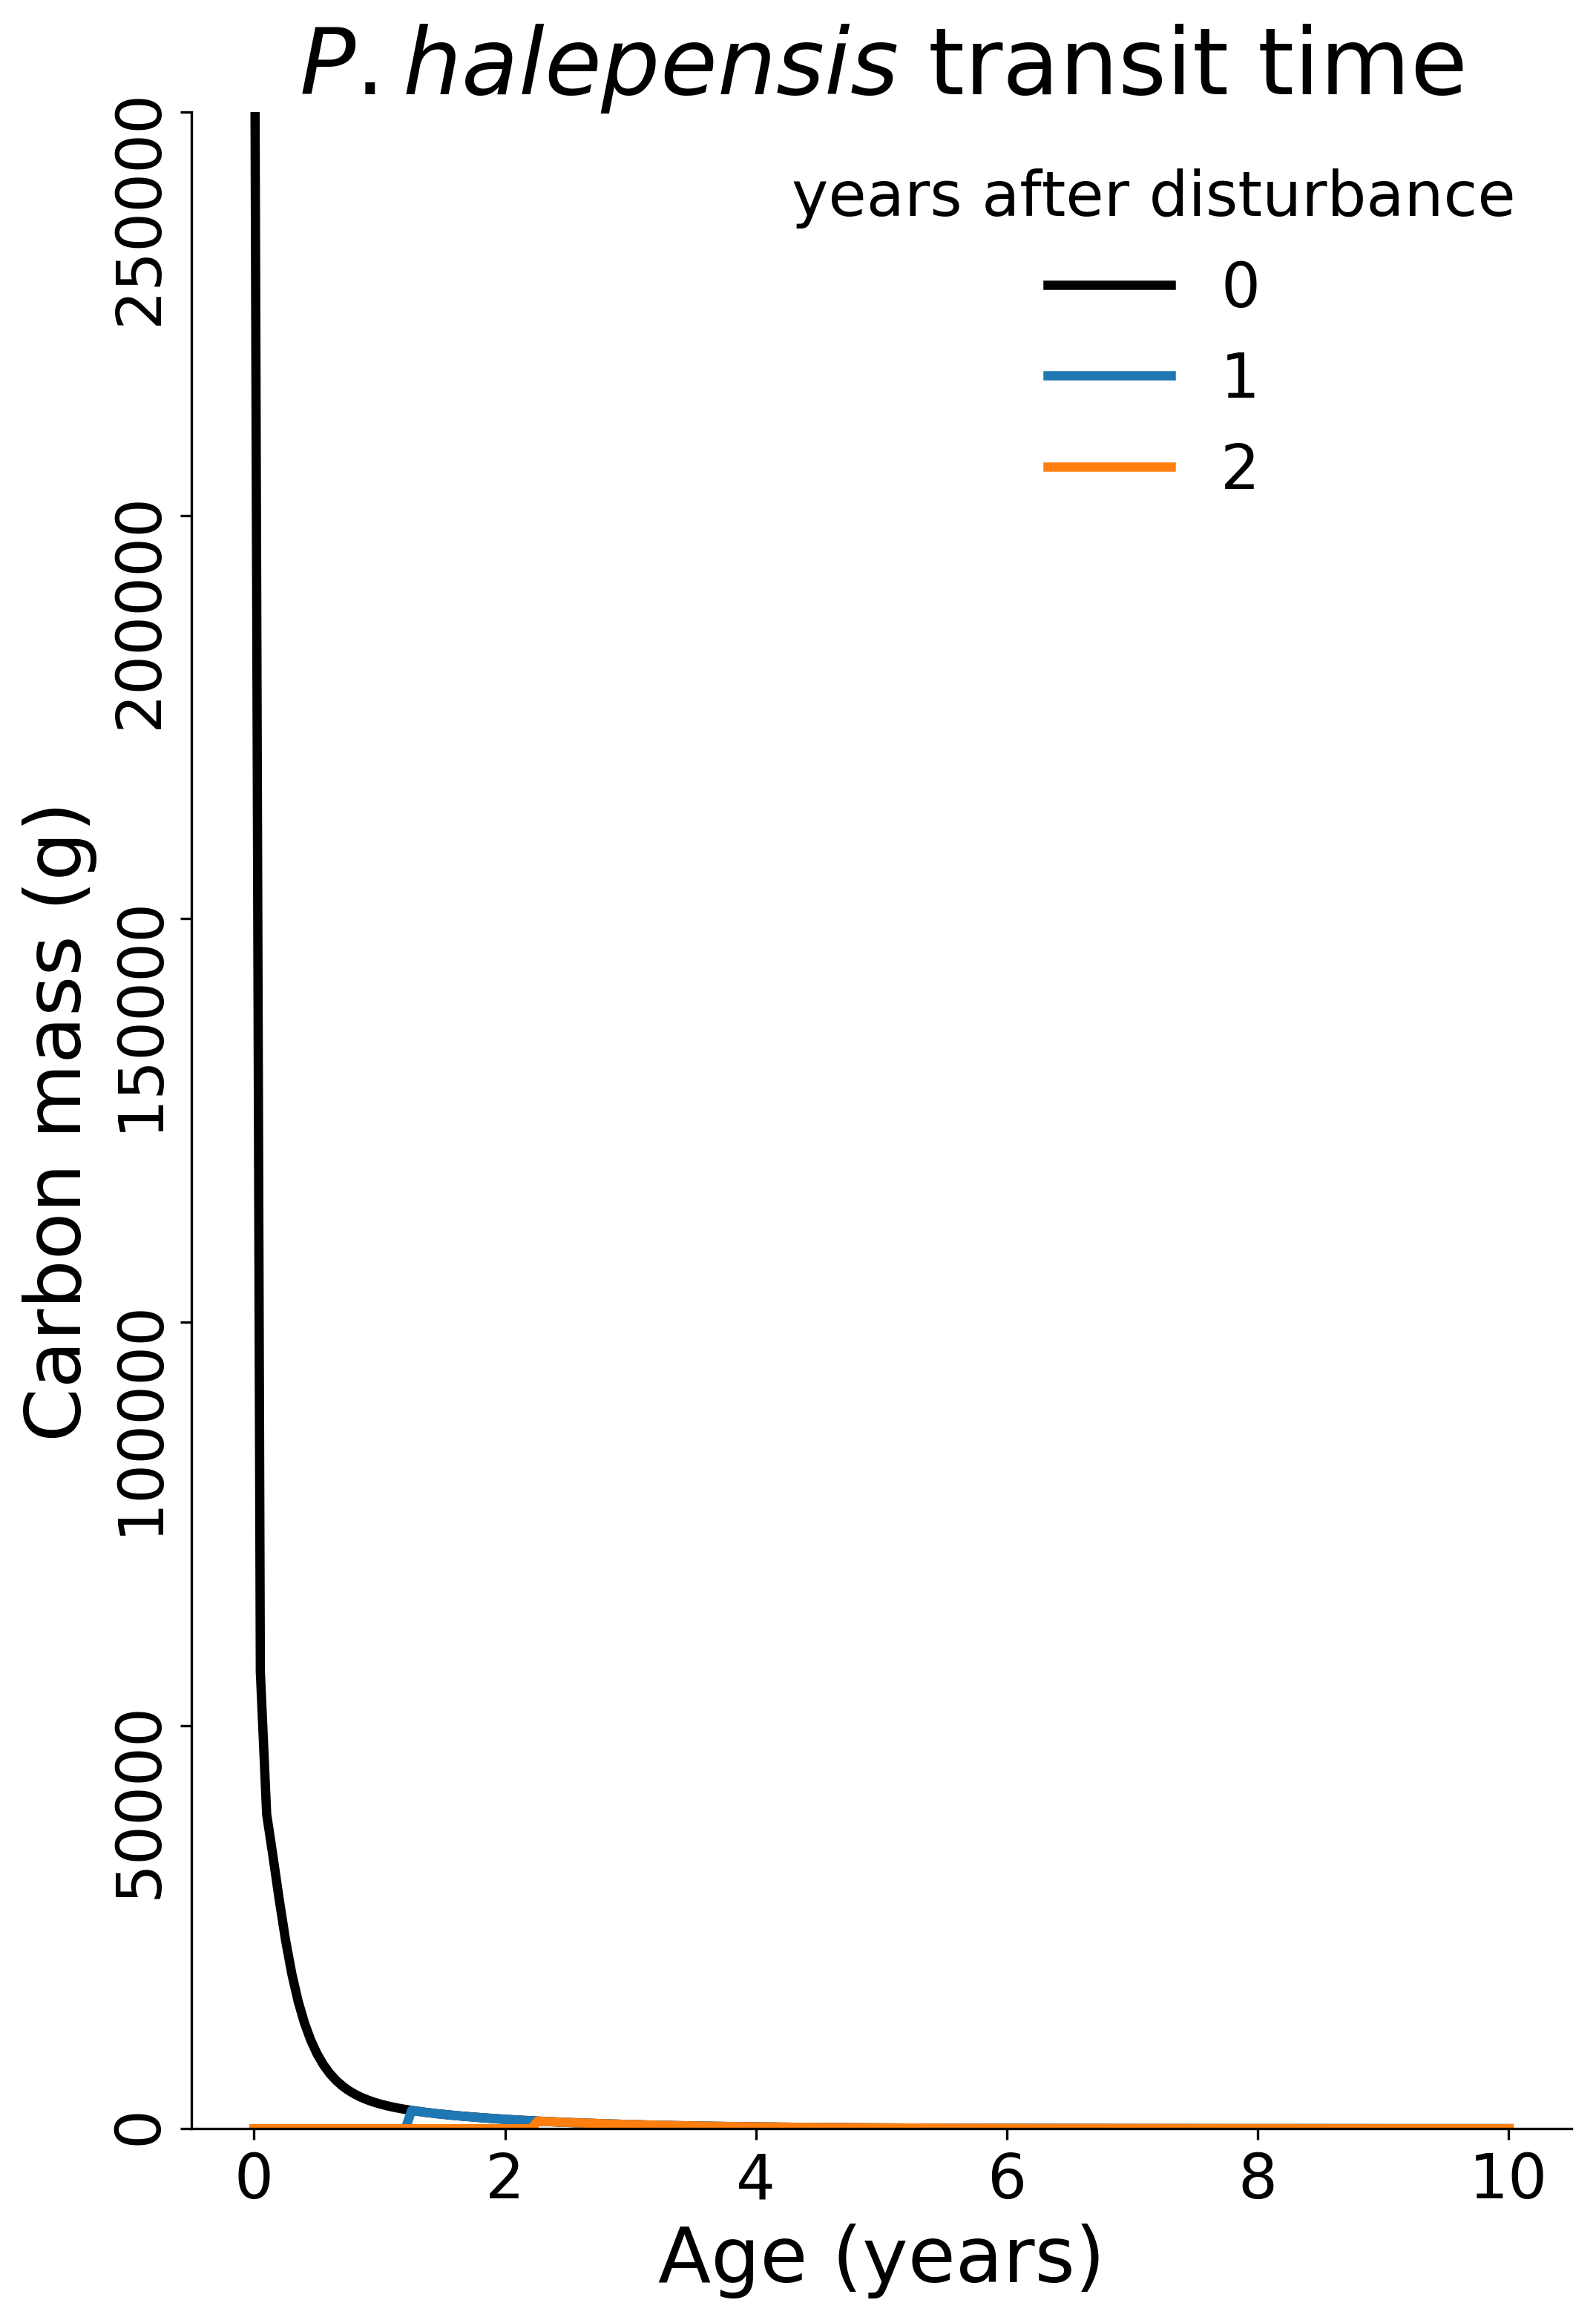

In [12]:
fig=plt.figure(figsize=(8,12), dpi=300)
ax=plt.subplot()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(ages, btt_dens[:,1], color="black", linewidth=3)
ax.plot(ages, btt_dens[:,11], color="#1f77b4",linewidth=3)
ax.plot(ages, btt_dens[:,12], color="#ff7f0e",linewidth=3)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.yticks(rotation=90)
plt.xlabel('Age (years)', fontsize=25)
plt.ylabel('Carbon mass (g)',fontsize=25)
plt.ylim(0,250000)
plt.title('$\it{P. halepensis}$ transit time', fontsize=30)
plt.legend(["0","1", "2"], 
           title="years after disturbance",
           fontsize=20, 
           title_fontsize=20,
           frameon=False)


#plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/NSC_ages_and_transit_times/code/P_halepensis/P_halepensis_transit_time_afterdist.png', dpi=300)
#plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/NSC_ages_and_transit_times/code/P_halepensis/P_halepensis_transit_time_afterdist.pdf', dpi=300)

plt.show()

12. We computed the amount NSC in each tree pool during the entire time frame of the simulation. The first 10 years refelct the steady state conditions and the subsequent years show how the carbon content gets depleted while the carbon is consumed. Then, the carbon content per pool is summed between all the pools to calculate the system NSC contet. 

In [13]:
poolsolution=smr.solve()
systemsolution=np.sum(poolsolution, 1)

In [14]:
systemsolution

array([1.14799161e+04, 1.14799161e+04, 1.14799161e+04, 1.14799161e+04,
       1.14799161e+04, 1.14799161e+04, 1.14799161e+04, 1.14799161e+04,
       1.14799161e+04, 1.14799161e+04, 8.45616285e+03, 3.24485547e+03,
       1.39173273e+03, 5.95753901e+02, 2.54072775e+02, 1.07982449e+02,
       4.57532473e+01, 1.93341194e+01, 8.15081029e+00, 3.42903277e+00,
       1.43992694e+00, 6.03665623e-01, 2.52706725e-01, 1.05649814e-01,
       4.41175683e-02, 1.84033414e-02, 7.66955647e-03, 3.19354907e-03,
       1.32875225e-03, 5.52475276e-04, 2.29569269e-04, 9.53400576e-05,
       3.95768965e-05, 1.64146851e-05, 6.80149392e-06, 2.81303748e-06,
       1.16031338e-06, 4.79032871e-07, 1.90477082e-07, 7.10304160e-08,
       2.57248303e-08, 1.00990367e-08, 3.96667696e-09, 1.53925330e-09,
       6.12287346e-10, 2.39294706e-10, 9.87962312e-11, 5.01415161e-11,
       2.41512975e-11, 1.04570160e-11])

13. The system carbon content is expressed as a fraction of the initial carbon content for each year of the simulation. 

In [15]:
Rel_systemsol=(systemsolution/systemsolution[1])*100
Rel_systemsol

array([1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 1.00000000e+02, 7.36604932e+01, 2.82654980e+01,
       1.21231959e+01, 5.18953182e+00, 2.21319365e+00, 9.40620540e-01,
       3.98550362e-01, 1.68416904e-01, 7.10006083e-02, 2.98698417e-02,
       1.25430092e-02, 5.25844976e-03, 2.20129417e-03, 9.20301265e-04,
       3.84302183e-04, 1.60309023e-04, 6.68084713e-05, 2.78185749e-05,
       1.15745815e-05, 4.81253756e-06, 1.99974691e-06, 8.30494373e-07,
       3.44749003e-07, 1.42986106e-07, 5.92468955e-08, 2.45039898e-08,
       1.01073332e-08, 4.17279068e-09, 1.65922015e-09, 6.18736367e-10,
       2.24085525e-10, 8.79713457e-11, 3.45531876e-11, 1.34082278e-11,
       5.33355243e-12, 2.08446389e-12, 8.60600635e-13, 4.36775979e-13,
       2.10378692e-13, 9.10896546e-14])

14. Then we inverted the consumtion fraction to express a consumption fraction

In [16]:
## relative amount of carbon consumed by the system after everytime step 
Rel_systemsol2=(Rel_systemsol-100)*-1

15. We built the P. halepensis part of the Figure 6 in the manuscript. Here we used the mean backward transit time and the consumption fraction of carbon in the NSC system.

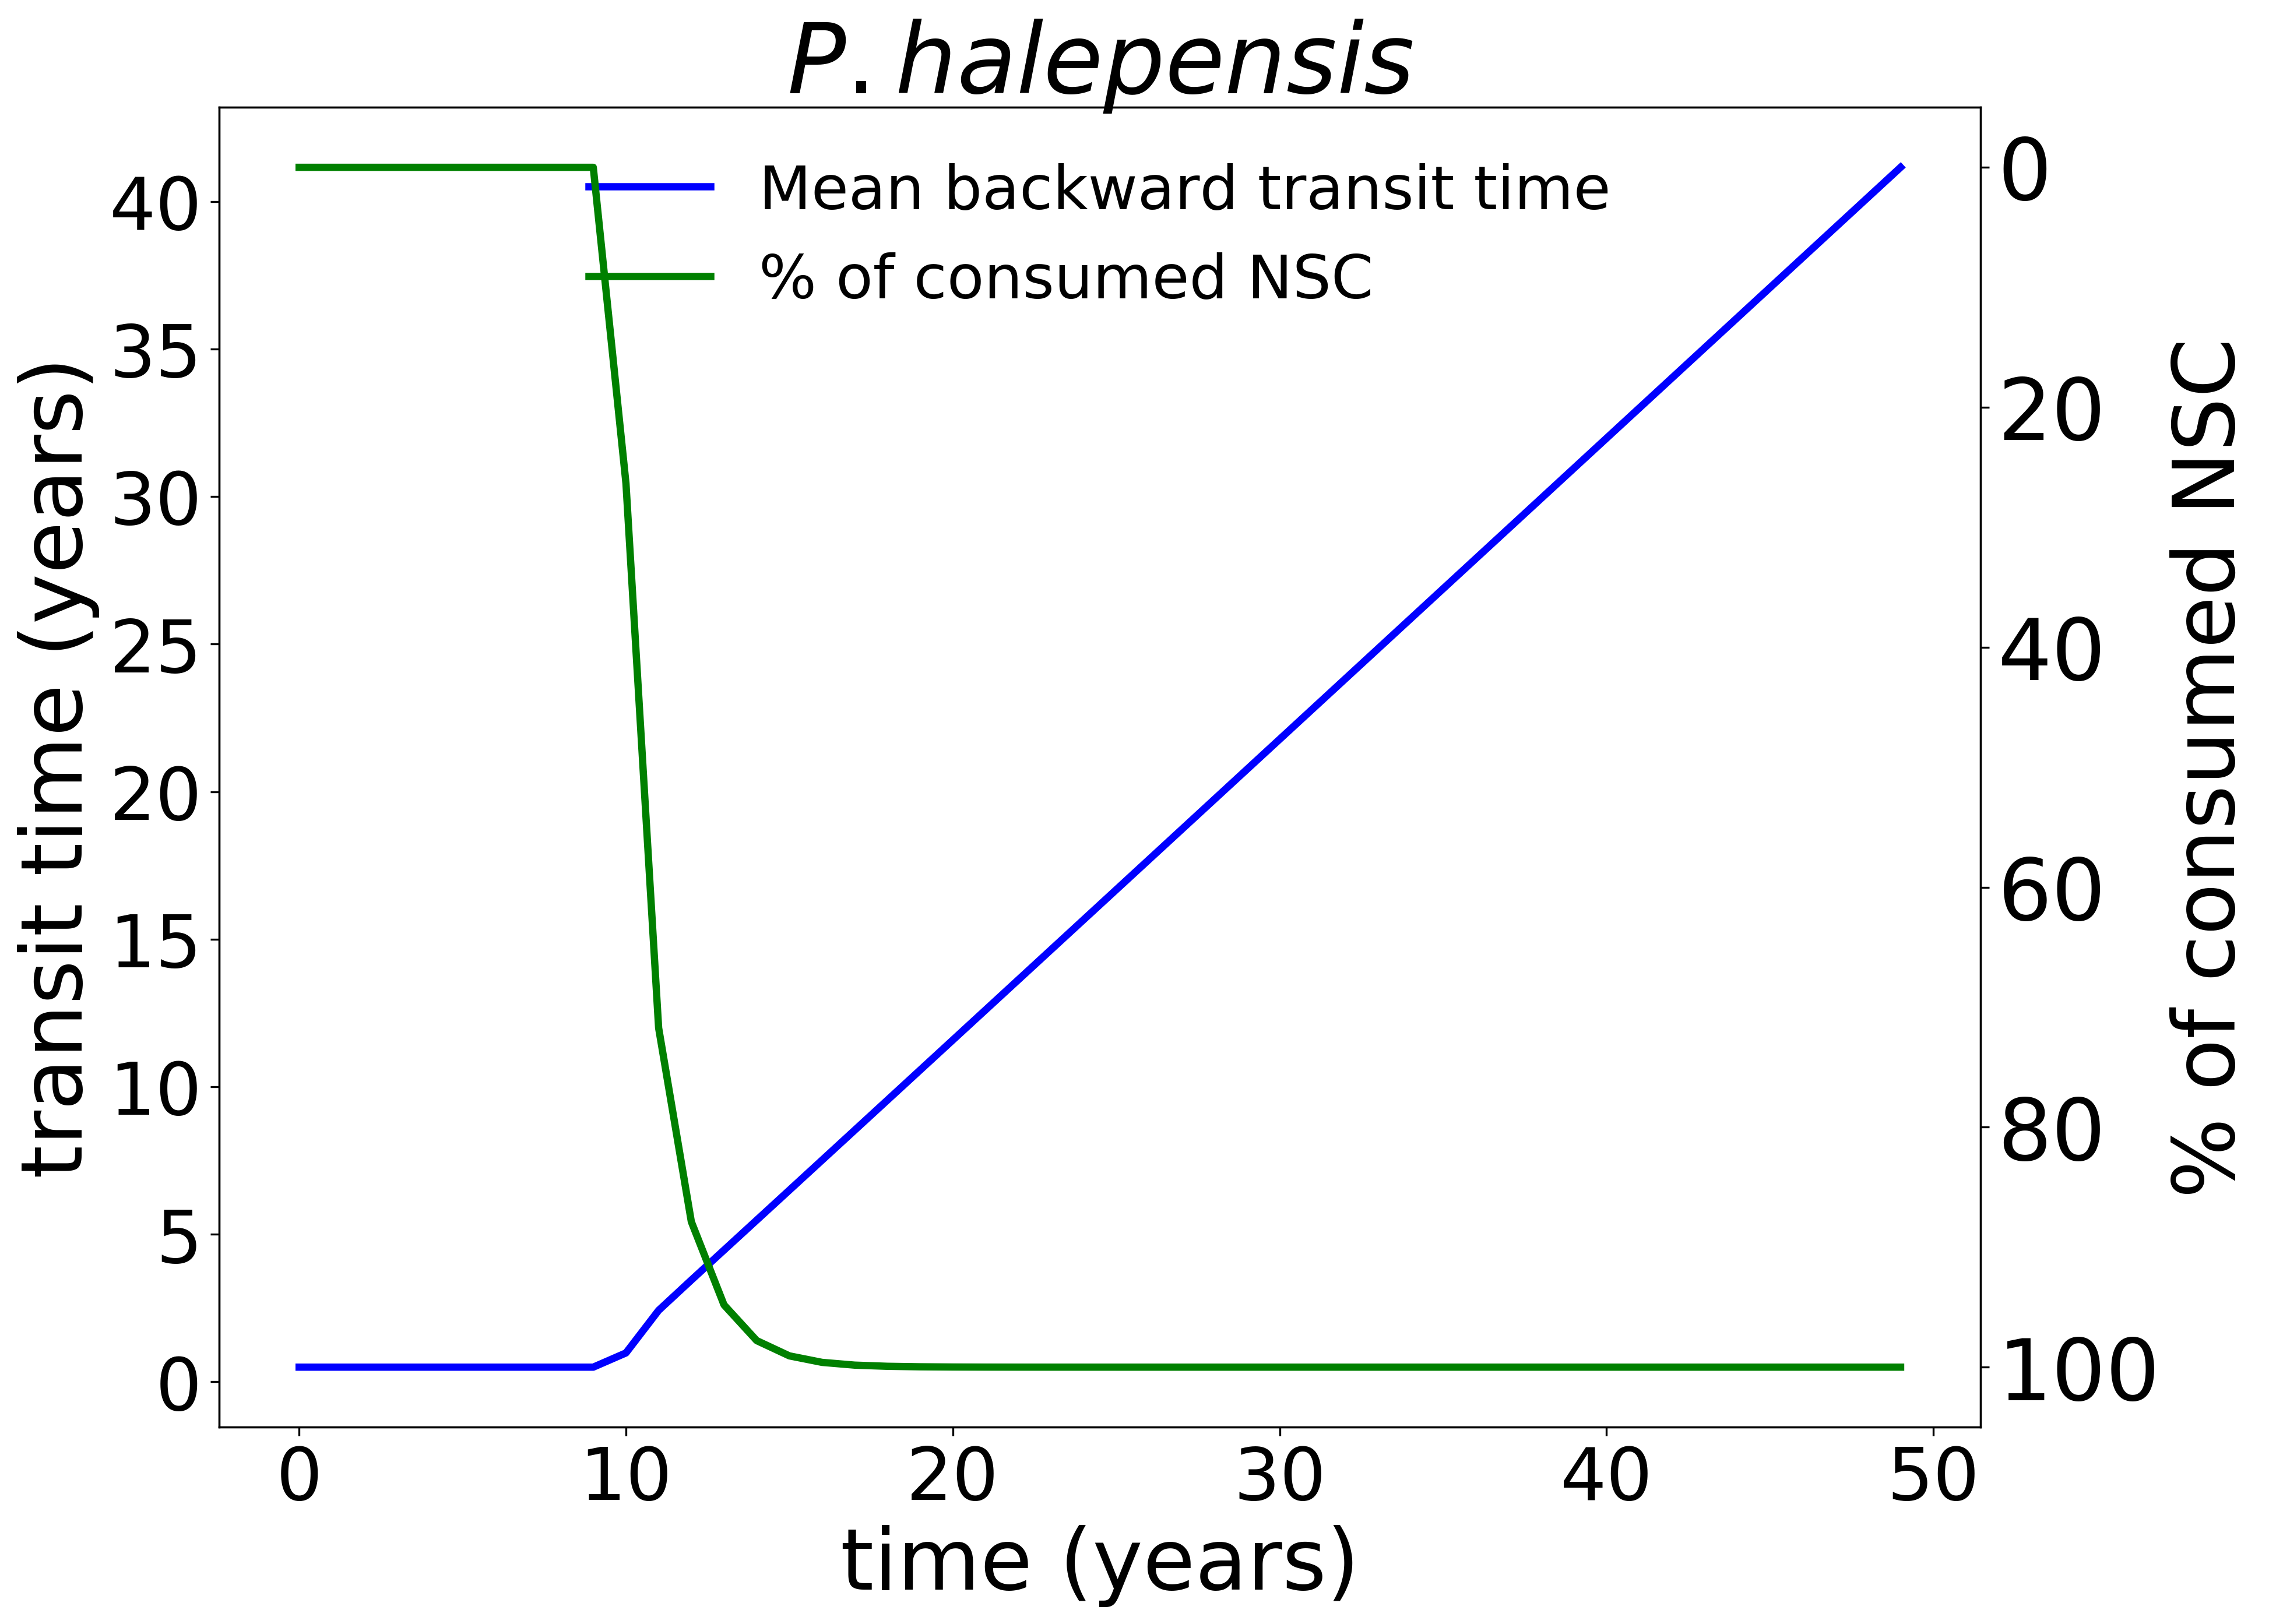

In [17]:
plt.figure(figsize=(13,10), dpi=300)
bttax=plt.subplot()
lns1=bttax.plot(btt_moment, linewidth=3, color="blue", label="Mean backward transit time")
bttax.set_xlabel('time (years)', fontsize=35)
bttax.set_ylabel('transit time (years)',fontsize=35)
bttax.tick_params(labelsize=30)
bttax2=bttax.twinx()
lns2=bttax2.plot(Rel_systemsol,  linewidth=3, color="green", label="% of consumed NSC")
bttax2.set_ylabel('% of consumed NSC',fontsize=35)
bttax2.tick_params(labelsize=35)
bttax2.yaxis.set_major_formatter(plt.FixedFormatter([100,100,80,60,40,20,0]))
plt.title('$\it{P. halepensis}$', fontsize=40)
lns=lns1+lns2
labs = [l.get_label() for l in lns]
bttax.legend(lns, labs, frameon=False, fontsize=25, loc="upper center")
#plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/NSC_ages_and_transit_times/code/P_halepensis/P_halepensis_btt_sol.png', 
#            dpi=300,
#            bbox_inches='tight')
#plt.savefig('/Users/_dherrera/NSC_ages_and_transit_times/NSC_ages_and_transit_times/code/P_halepensis/P_halepensis_btt_sol.pdf', 
#            dpi=300,
#            bbox_inches='tight')
fig.tight_layout()

plt.show()